# Global map of drag coefficient (M2 vs. K1)

In [1]:
%matplotlib inline

import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from dask.distributed import Client
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from gsw import f, Nsquared, p_from_z, z_from_p
  
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42513/status,
Dashboard: /proxy/42513/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42505,Workers: 4
Dashboard: /proxy/42513/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:38583,Total threads: 1
Dashboard: /proxy/46369/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:40807,


In [3]:
nx = 360
ny = 180
lat_k1 = np.full((ny),np.nan)
lon_k1 = np.full((nx),np.nan)
lat_m2 = np.full((ny),np.nan)
lon_m2 = np.full((nx),np.nan)
sigma_xx_k1 = np.full((ny,nx),np.nan)
sigma_yy_k1 = np.full((ny,nx),np.nan)
sigma_xy_k1 = np.full((ny,nx),np.nan)
sigma_xx_m2 = np.full((ny,nx),np.nan)
sigma_yy_m2 = np.full((ny,nx),np.nan)
sigma_xy_m2 = np.full((ny,nx),np.nan)
depth_z = np.full((ny,nx),np.nan)

## Loop through tiles and re-construct drag coefficient arrays

In [4]:
for i in range(400):
    # print(i+1)
    filename_k1 = '/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_K1_2d_%03d.nc' % (i+1)
    # print(filename)
    itile_k1 = xr.open_dataset(filename_k1)

    # infer the lon & lat from itile
    ilon = i//20+1
    ilat = i+1 - (ilon-1)*20
    # print(ilon,ilat)
    
    lon_k1[(ilon-1)*18:ilon*18] = itile_k1.lon
    lat_k1[(ilat-1)*9:ilat*9] = itile_k1.lat
    sigma_xx_k1[(ilat-1)*9:ilat*9,(ilon-1)*18:ilon*18] = itile_k1.sigma_xx_k1
    sigma_yy_k1[(ilat-1)*9:ilat*9,(ilon-1)*18:ilon*18] = itile_k1.sigma_yy_k1
    sigma_xy_k1[(ilat-1)*9:ilat*9,(ilon-1)*18:ilon*18] = itile_k1.sigma_xy_k1

sigma_k1 = np.sqrt(sigma_xx_k1**2+sigma_yy_k1**2)

0.3.0


In [5]:
for i in range(400):
    # print(i+1)
    filename_m2 = '/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_M2_2d_%03d.nc' % (i+1)
    # print(filename)
    itile_m2 = xr.open_dataset(filename_m2)

    # infer the lon & lat from itile
    ilon = i//20+1
    ilat = i+1 - (ilon-1)*20
    # print(ilon,ilat)
    
    lon_m2[(ilon-1)*18:ilon*18] = itile_m2.lon
    lat_m2[(ilat-1)*9:ilat*9] = itile_m2.lat
    sigma_xx_m2[(ilat-1)*9:ilat*9,(ilon-1)*18:ilon*18] = itile_m2.sigma_xx_m2
    sigma_yy_m2[(ilat-1)*9:ilat*9,(ilon-1)*18:ilon*18] = itile_m2.sigma_yy_m2    
    sigma_xy_m2[(ilat-1)*9:ilat*9,(ilon-1)*18:ilon*18] = itile_m2.sigma_xy_m2

sigma_m2 = np.sqrt(sigma_xx_m2**2+sigma_yy_m2**2)

## Ocean depth

In [6]:
topog = xr.open_dataset('/g/data/nm03/lxy581/synbath/SYNBATH.nc')

def get_depth(lon,lat):
    return topog.z.interp(lat=lat,lon=lon).values

In [7]:
for j in range(ny):
    for i in range(nx):
        depth_z[j,i] = get_depth(lon_k1[i],lat_k1[j])

In [8]:
depth_z[depth_z>0]=np.nan
depth_xr = xr.DataArray(depth_z, coords={'lat': lat_k1, 'lon': lon_k1}, dims=["lat", "lon"])

In [9]:
np.nanmin(depth_z)

-9522.77929687501

In [10]:
sigma_k1_xr = xr.DataArray(sigma_k1, coords={'lat': lat_k1, 'lon': lon_k1}, dims=["lat", "lon"])
sigma_m2_xr = xr.DataArray(sigma_m2, coords={'lat': lat_m2, 'lon': lon_m2}, dims=["lat", "lon"])

## Interpolate to remove the missing band near 180°

In [11]:
mask_k1 = ~np.isnan(sigma_k1)
ds_k1 = xr.Dataset(data_vars={
                    'sigma': (('lat','lon'), sigma_k1),
                    'mask': (('lat','lon'), mask_k1)
                    }, 
                    coords={'lon': sigma_k1_xr.lon,'lat': sigma_k1_xr.lat})
ds_out_k1 = xr.Dataset({"lat": (["lat"], lat_k1[16:-16]),
                         "lon": (["lon"], lon_k1),
                         "mask": (["lat","lon"], ~np.isnan(depth_z[16:-16,:]))})
regridder = xe.Regridder(ds_k1, ds_out_k1, "bilinear", extrap_method="inverse_dist")
ds_out_k1 = regridder(ds_k1)

In [12]:
mask_m2 = ~np.isnan(sigma_m2)
ds_m2 = xr.Dataset(data_vars={
                    'sigma': (('lat','lon'), sigma_m2),
                    'mask': (('lat','lon'), mask_m2)
                    }, 
                    coords={'lon': sigma_m2_xr.lon,'lat': sigma_m2_xr.lat})
ds_out_m2 = xr.Dataset({"lat": (["lat"], lat_m2[16:-16]),
                         "lon": (["lon"], lon_m2),
                         "mask": (["lat","lon"], ~np.isnan(depth_z[16:-16,:]))})
regridder = xe.Regridder(ds_m2, ds_out_m2, "bilinear", extrap_method="inverse_dist")
ds_out_m2 = regridder(ds_m2)

## Interpolate to 1/4° grid

In [13]:
omega = 2 * np.pi / (23.93*3600)
f_loc = f(30) 
print(omega)
print(f_loc)

7.293477860402547e-05
7.292114999999999e-05


In [14]:
ds_low_k1 = xr.Dataset(data_vars={
                                   'sigma_25': (('lat','lon'), np.array(ds_out_k1['sigma'])),
                                   'mask': (('lat','lon'), ~np.isnan(depth_z[16:-16,:]))
                                   }, 
                        coords={'lon': ds_out_k1['lon'],'lat': ds_out_k1['lat']})
ds_high_k1 = xr.Dataset({"lat": (["lat"], np.arange(-30,30+0.25,0.25)),
                          "lon": (["lon"], np.arange(-180,180+0.25,0.25)),
                         })
regridder2 = xe.Regridder(ds_low_k1, ds_high_k1, "bilinear", extrap_method="inverse_dist")
ds_high_k1 = regridder2(ds_low_k1)

In [15]:
ds_low_m2 = xr.Dataset(data_vars={
                                   'sigma_25': (('lat','lon'), np.array(ds_out_m2['sigma'])),
                                   'mask': (('lat','lon'), ~np.isnan(depth_z[16:-16,:]))
                                   }, 
                        coords={'lon': ds_out_m2['lon'],'lat': ds_out_m2['lat']})
ds_high_m2 = xr.Dataset({"lat": (["lat"], np.arange(-75,75+0.25,0.25)),
                          "lon": (["lon"], np.arange(-180,180+0.25,0.25)),
                         })
regridder2 = xe.Regridder(ds_low_m2, ds_high_m2, "bilinear", extrap_method="inverse_dist")
ds_high_m2 = regridder2(ds_low_m2)

## Plot drag coefficient

In [16]:
def plot_global(lon,lat,sigma,vmin,vmax,title,cmap):
    fig = plt.figure(figsize=(8, 6))
    ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    
    # Add model land mask
    land = xr.where(np.isnan(depth_xr[:,:].rename('land')), 1, np.nan)
    land.plot.contourf(ax=ax1, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # # Add model coastline
    land.fillna(0).plot.contour(ax=ax1, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)
    
    p1 = ax1.pcolormesh(lon, lat, sigma, transform=ccrs.PlateCarree(), cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.title(title)
    
    ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
    cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel(r'$\sigma$ (m s$^{-1}$)');
    return 

In [17]:
def plot_global_ratio(lon,lat,sigma,vmin,vmax,title,cmap):
    fig = plt.figure(figsize=(8, 6))
    ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    
    # Add model land mask
    land = xr.where(np.isnan(depth_xr[:,:].rename('land')), 1, np.nan)
    land.plot.contourf(ax=ax1, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # # Add model coastline
    land.fillna(0).plot.contour(ax=ax1, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)
    
    p1 = ax1.pcolormesh(lon, lat, sigma, transform=ccrs.PlateCarree(), cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.title(title)
    
    ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
    cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel('$\sigma(K_1)/\sigma(M_2)$');
    return 

In [18]:
def plot_global_ratio_lin(lon,lat,sigma,vmin,vmax,title,cmap):
    fig = plt.figure(figsize=(8, 6))
    ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    
    # Add model land mask
    land = xr.where(np.isnan(depth_xr[:,:].rename('land')), 1, np.nan)
    land.plot.contourf(ax=ax1, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # # Add model coastline
    land.fillna(0).plot.contour(ax=ax1, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)
    
    p1 = ax1.pcolormesh(lon, lat, sigma, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    
    ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
    cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel('$\sigma(K_1)/\sigma(M_2)$');
    return 

In [19]:
def plot_global_lin(lon,lat,sigma,vmin,vmax,title,cmap):
    fig = plt.figure(figsize=(8, 6))
    ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    
    # Add model land mask
    land = xr.where(np.isnan(depth_xr[:,:].rename('land')), 1, np.nan)
    land.plot.contourf(ax=ax1, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # # Add model coastline
    land.fillna(0).plot.contour(ax=ax1, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)
    
    p1 = ax1.pcolormesh(lon, lat, sigma, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    
    ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
    cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel(r'$\sigma$ (m s$^{-1}$)');
    return 

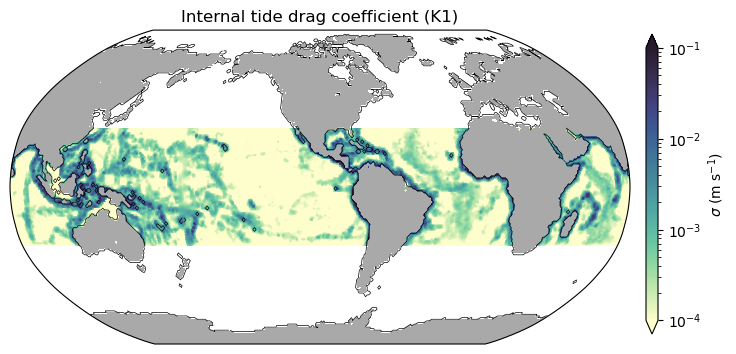

In [20]:
# Log scale
plot_global(ds_high_k1['lon'],ds_high_k1['lat'],ds_high_k1['sigma_25'],1e-4,1e-1,'Internal tide drag coefficient (K1)',cmap=cm.cm.deep)
plt.savefig('/g/data/nm03/lxy581/global_drag_coeff/drag_coeff_SAH_K1_025.png', dpi=300, bbox_inches='tight')

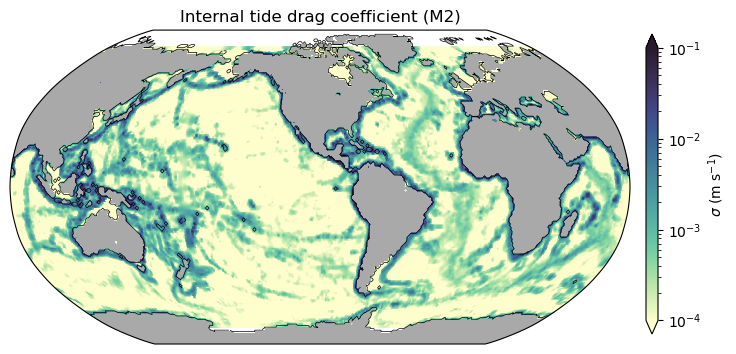

In [21]:
plot_global(ds_high_m2['lon'],ds_high_m2['lat'],ds_high_m2['sigma_25'],1e-4,1e-1,'Internal tide drag coefficient (M2)',cmap=cm.cm.deep)
plt.savefig('/g/data/nm03/lxy581/global_drag_coeff/drag_coeff_SAH_M2_025.png', dpi=300, bbox_inches='tight')

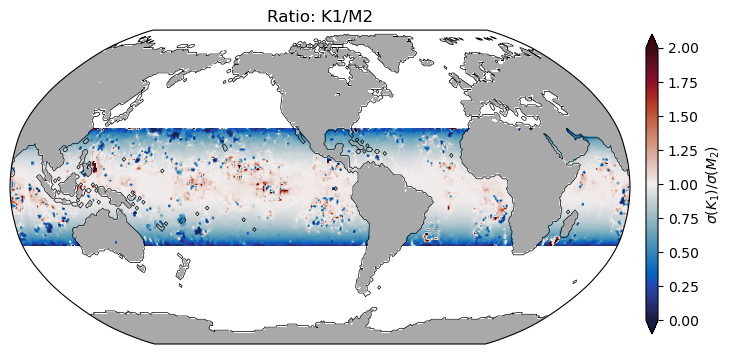

In [22]:
plot_global_ratio_lin(ds_high_k1['lon'],ds_high_k1['lat'],ds_high_k1['sigma_25']/ds_high_m2['sigma_25'],0,2,'Ratio: K1/M2',cmap=cm.cm.balance)
plt.savefig('/g/data/nm03/lxy581/global_drag_coeff/drag_coeff_ratio_M2_K1_025_lin.png', dpi=300, bbox_inches='tight')

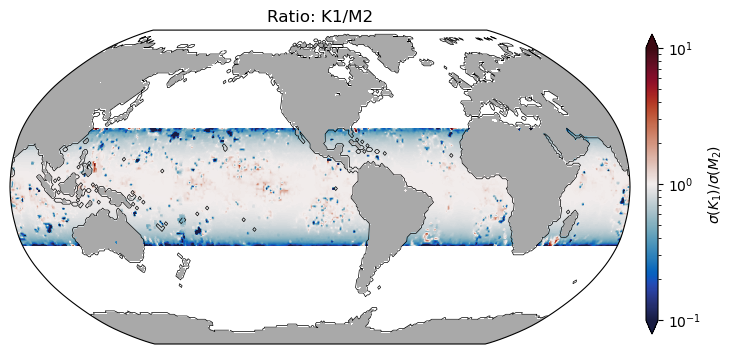

In [23]:
plot_global_ratio(ds_high_k1['lon'],ds_high_k1['lat'],ds_high_k1['sigma_25']/ds_high_m2['sigma_25'],1e-1,1e+1,'Ratio: K1/M2',cmap=cm.cm.balance)
plt.savefig('/g/data/nm03/lxy581/global_drag_coeff/drag_coeff_ratio_M2_K1_025.png', dpi=300, bbox_inches='tight')